## Numerical Simulation of Intensity and Phase Noise From Extracted Parameters for CW DFB Lasers" by I. Fatadin, D. Ives and M. Wicks.

In [108]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [109]:
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.signal as signal
from scipy.ndimage import shift
from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter, pulseShape
from optic.utils import parameters
from scipy.constants import h,e

In [110]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import optic.models.laser as laser

In [111]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [112]:
figsize(9,6)
plt.style.use('bmh')

## Simulation

In [113]:
laser_dfb_parameters = parameters()
laser_dfb_parameters.noise_terms = True
laser_dfb_parameters.v       = 1.0       # [cm3]  active layer volume
laser_dfb_parameters.tau_n   = 0.33e-9   # [s]    electron lifetime
laser_dfb_parameters.a0      = 2.50e-6   # [cm2]  active layer gain coefficient
laser_dfb_parameters.vg      = 4.52e+9   # [cm/s] group velocity
laser_dfb_parameters.n_t     = 8.2e6     # [cm-1] carrier density at transparency
laser_dfb_parameters.epsilon = 4.58e-8   # [cm3] gain compression factor
laser_dfb_parameters.tau_p   = 7.15e-12  # [s] photon lifetime
laser_dfb_parameters.gamma   = 1.0       # mode confinement factor
laser_dfb_parameters.beta    = 3.54e-5   # fraction of spontaneous emission coupling
laser_dfb_parameters.alpha   = 1.55      # linewidth enchancement factor
laser_dfb_parameters.sigma   = 2e-20     # gain cross section
laser_dfb_parameters.i_bias  = 0.0129    # [A] i_bias
laser_dfb_parameters.i_max   = 0.0300    # [A] i_max
laser_dfb_parameters.eta_0   = 0.21      # total differential quantum efficiency
laser_dfb_parameters.lmbd    = .5*1554.3e-9 # [m] wavelength

In [114]:
# simulation parameters
SpS = 256
Rs = 2.5e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

In [115]:
# generate pseudo-random bit sequence
bitsTx = [0,1,0,1,0] 

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [116]:
# RC filter
def rc_filter(R, C, Fs, filter_type):
    if (1/(2*np.pi*R*C) > Fs/2):
        ('This analog filter cannot be realized with this sample rate')    
    # Default to allpass if invalid type is selected
    b = [1, 0]
    a = [1, 0]
    # Constants
    RC = R * C
    T  = 1 / Fs
    # Analog Cutoff Fc
    w = 1 / (RC)
    # Prewarped coefficient for Bilinear transform
    A = 1 / (np.tan((w*T) / 2))
    if(filter_type=='high'):
        b[0] = (A)     / (1 + A)
        b[1] = -b[0]
        a[1] = (1 - A) / (1 + A)
    if(filter_type=='low'):
        b[0] = (1)     / (1 + A)
        b[1] = b[0]
        a[1] = (1 - A) / (1 + A)
    return a,b
# Filter parameters
R = 59.17
C = 1.e-12
# Filter cut-off
f_cut = 1./(2.*np.pi*R*C)
# Signal filtering
a,b=rc_filter(R, C, Fs, 'low')
zi = signal.lfilter_zi(b, a)
z, _ = signal.lfilter(b, a, sigTx, zi=zi*sigTx[0])

c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Adolfo\mambaforge\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


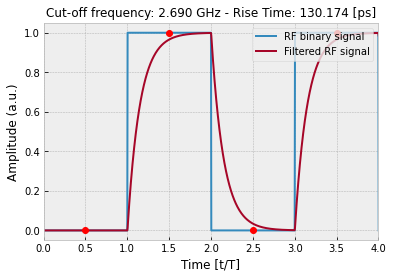

In [117]:
# Plot bits, rf signal and filtered signal
plt.figure(figsize=(6,4))
plt.plot(t*Rs, sigTx, label = 'RF binary signal', linewidth=2)
plt.plot(t*Rs, z, label = 'Filtered RF signal', linewidth=2)
plt.plot(t[int(SpS/2)::SpS]*Rs, bitsTx, 'ro')
plt.title('Cut-off frequency: %.3f GHz - Rise Time: %.3f [ps]'%(1e-9*f_cut,2.2*R*C*1e12), fontsize=12)
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time [t/T]')
plt.xlim([0,4])
plt.legend(loc='upper right')
plt.grid(True)

In [118]:
current = parameters()
current.t = t
current.signal = z

In [119]:
# Solve rate equations
laser_dfb_parameters,current,sol = laser.laser_dfb(laser_dfb_parameters,current)
out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)

c:\Users\Adolfo\Documents\GitHub\OptiCommPy\optic\models\laser.py:449: RuntimeWarning: invalid value encountered in sqrt
  fs = np.random.randn() * np.sqrt(dss) * t_step_sqrt
c:\Users\Adolfo\Documents\GitHub\OptiCommPy\optic\models\laser.py:450: RuntimeWarning: invalid value encountered in sqrt
  fp = np.random.randn() * np.sqrt(dpp) * t_step_sqrt
c:\Users\Adolfo\Documents\GitHub\OptiCommPy\optic\models\laser.py:451: RuntimeWarning: invalid value encountered in sqrt
  fz = np.random.randn() * np.sqrt(dzz) * t_step_sqrt


In [120]:
def dpc_axis(ax,x,y):
    axt = ax.twinx()
    axt.plot(x, y,'r--',alpha=0.5)
    axt.grid(False)
    axt.tick_params(right=False, labelright=False)
    return axt

Max. chirp freq. excursion: 6.383 GHz
Min. chirp freq. excursion: -1.900 GHz
I_threshold: 9.990 mA
I_on: 42.865 mA
I_off: 12.900 mA


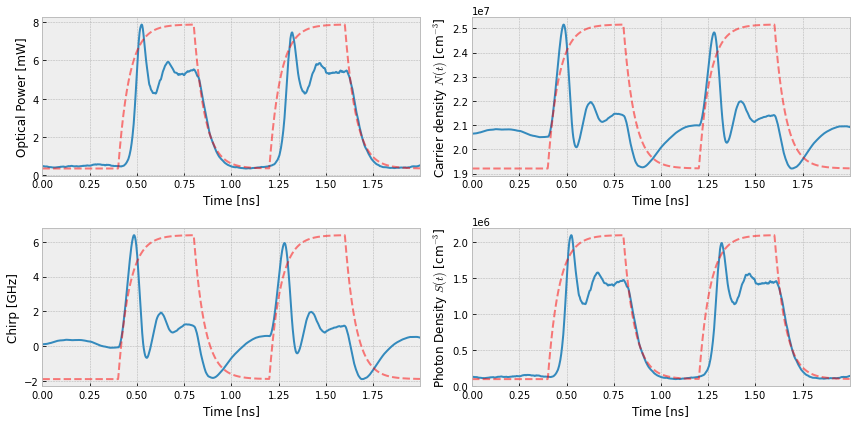

In [121]:
ax = laser.plot(current.t,out)
dpc_axis(ax[0,0],1e9*current.t, 1e3*current.signal)
dpc_axis(ax[0,1],1e9*current.t, 1e3*current.signal)
dpc_axis(ax[1,0],1e9*current.t, 1e3*current.signal)
dpc_axis(ax[1,1],1e9*current.t, 1e3*current.signal)
# See pag. 58 from Espeyear reference.
print('Max. chirp freq. excursion: %.3f GHz' %(1e-9*out.chirp.max()))
print('Min. chirp freq. excursion: %.3f GHz' %(1e-9*out.chirp.min()))
print('I_threshold: %.3f mA'%(1e3*laser_dfb_parameters.ith))
print('I_on: %.3f mA'%(1e3*np.real(current.signal.max())))
print('I_off: %.3f mA'%(1e3*np.real(current.signal.min())))

### RIN and Linewidth

In [122]:
# simulation parameters
SpS = 16
Rs = 4*3.125e9   # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period

In [123]:
# generate bit sequence of "0"
bitsTx = np.zeros(2**12)

# upsampling
symbolsUp = upsample(bitsTx, SpS)

# typical NRZ pulse
pulse = pulseShape('rect', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)
sigTx = shift(sigTx, int(SpS/2), cval=sigTx[0])
t = np.arange(0,SpS*len(bitsTx))*Ts

In [124]:
# information TX
print('Number of points: %d' %(len(sigTx)))
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*len(sigTx)/Fs))
print('Time spacing [ps]:  %5.3f' %(1e12*Ts))
print('Frequency spacing [GHz]: %f' %(1e-9*Fs/len(sigTx)))
print('Central wavelength [nm]: %6.2f' %(1e9*laser_dfb_parameters.lmbd))
print('')

Number of points: 65536
Sample rate [THz]: 0.200
Time window [ns]:  327.680
Time spacing [ps]:  5.000
Frequency spacing [GHz]: 0.003052
Central wavelength [nm]: 777.15



In [125]:
current = parameters()
current.t = t
current.signal = sigTx

In [126]:
# Solve rate equations
laser_dfb_parameters,current,sol = laser.laser_dfb(laser_dfb_parameters,current)
out = laser.laser_dynamic_response(sol['y'], laser_dfb_parameters)

(100000.0, 160000.0)

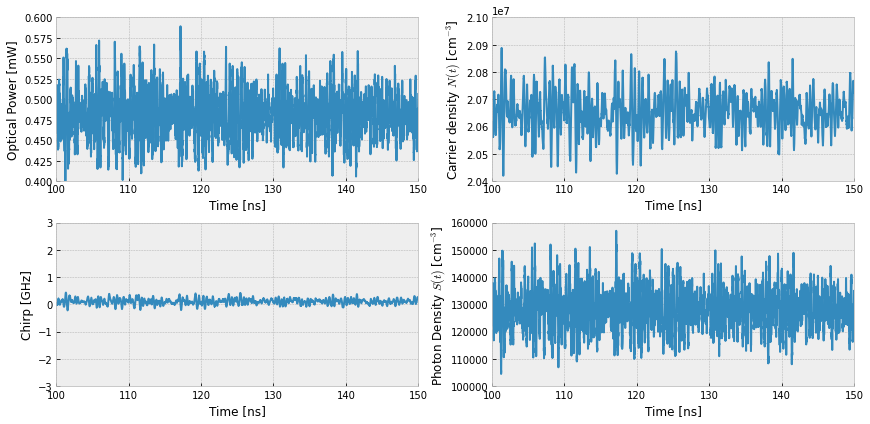

In [127]:
ax = laser.plot(current.t,out)
ax[0,0].set_xlim([100,150])
ax[0,0].set_ylim([0.4,0.6])
ax[1,0].set_xlim([100,150])
ax[1,0].set_ylim([-3,3])
ax[0,1].set_xlim([100,150])
ax[0,1].set_ylim([2.04e7,2.1e7])
ax[1,1].set_xlim([100,150])
ax[1,1].set_ylim([1.0e5,1.6e5])

(0.75, 1.15)

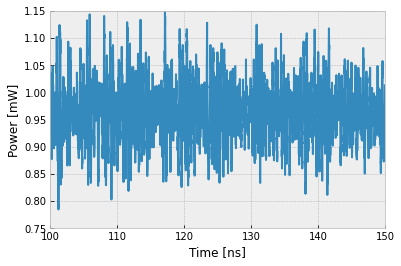

In [128]:
# Equation [13] of reference.
p_t = laser_dfb_parameters.eta_0*h*laser_dfb_parameters.freq_0/laser_dfb_parameters.tau_p * out.S
plt.figure(figsize=(6,4))
plt.plot(1e9*current.t, 1e3*p_t)
plt.xlabel('Time [ns]')
plt.ylabel('Power [mW]')
plt.xlim([100,150])
plt.ylim([.75,1.15])

In [129]:
indx = np.squeeze(np.argwhere(t > 100e-9))
p_t = p_t[indx[0]:]
p_mean  = np.mean(p_t)
p_delta = p_t #- p_mean

In [130]:
# Get RIN
F, P = signal.periodogram(p_delta, Fs, scaling='density')
rin = P/p_mean**2
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
rin_t = firFilter(b, rin)

(0.01, 10)

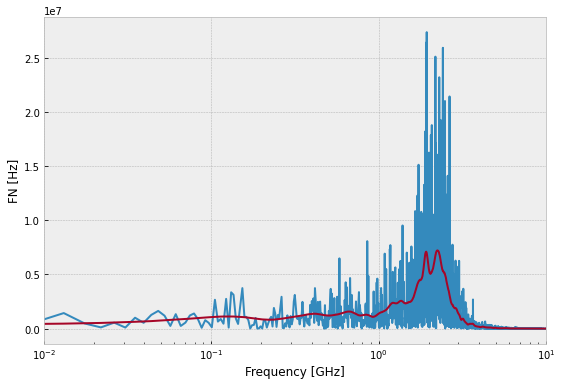

In [131]:
# Get FN
Fc, C = signal.periodogram(out.chirp[indx[:]], Fs, scaling='density')
# Filter
b = signal.firwin(numtaps = 50, cutoff = 0.01, window='hamming')
phase_noise = firFilter(b, C)
# Plot
plt.semilogx(1e-9*Fc,C)
plt.semilogx(1e-9*Fc,phase_noise)
plt.xlabel('Frequency [GHz]')
plt.ylabel('FN [Hz]')
plt.xlim([0.01,10])

In [132]:
# Analytical RIN
I = laser_dfb_parameters.i_bias
g = 1.13e4
# Normalize epsilon and n_t as Table I - from ref.
laser_dfb_parameters.epsilon = laser_dfb_parameters.epsilon/laser_dfb_parameters.v
laser_dfb_parameters.n_t = laser_dfb_parameters.n_t*laser_dfb_parameters.v

In [133]:
a = e*(laser_dfb_parameters.epsilon + g*laser_dfb_parameters.tau_n)
b = e+g*laser_dfb_parameters.tau_p*((1-laser_dfb_parameters.beta)*laser_dfb_parameters.n_t*e - laser_dfb_parameters.tau_n*I)-laser_dfb_parameters.beta*laser_dfb_parameters.epsilon*laser_dfb_parameters.tau_p*I
c = -laser_dfb_parameters.beta*laser_dfb_parameters.tau_p*I

In [134]:
S = (-b + np.sqrt(b**2-4*a*c))/(2*a)
N = (laser_dfb_parameters.tau_n/e)*((I*(1+laser_dfb_parameters.epsilon*S)+g*laser_dfb_parameters.n_t*e*S)/(1+laser_dfb_parameters.epsilon*S+g*S*laser_dfb_parameters.tau_n))

In [135]:
Y = 1/laser_dfb_parameters.tau_n + 1/laser_dfb_parameters.tau_p + g/(1+laser_dfb_parameters.epsilon*S) * (S-(N-laser_dfb_parameters.n_t)/(1+laser_dfb_parameters.epsilon*S))
Z = 1/(laser_dfb_parameters.tau_n*laser_dfb_parameters.tau_p)+ g/(1+laser_dfb_parameters.epsilon*S) * (S/laser_dfb_parameters.tau_p - ((1-laser_dfb_parameters.beta)/laser_dfb_parameters.tau_n) * (N-laser_dfb_parameters.n_t)/(1+laser_dfb_parameters.epsilon*S))
A = ((1/laser_dfb_parameters.tau_n**2)*((1-laser_dfb_parameters.beta)**2+laser_dfb_parameters.beta/S)+g/(1+laser_dfb_parameters.epsilon*S)*(2/laser_dfb_parameters.tau_n + (S/laser_dfb_parameters.beta) * (g/(1+laser_dfb_parameters.epsilon*S))))**-1
R = 2*(laser_dfb_parameters.tau_p**2)*((1+laser_dfb_parameters.epsilon*S)**2)*N
R = R * (laser_dfb_parameters.beta*(S*(1-laser_dfb_parameters.beta)**2+laser_dfb_parameters.beta)*(1+laser_dfb_parameters.epsilon*S)**2+g*S*laser_dfb_parameters.tau_n*(g*S*laser_dfb_parameters.tau_n+2*laser_dfb_parameters.beta*laser_dfb_parameters.epsilon*S+2*laser_dfb_parameters.beta))
R = R/(S**2*laser_dfb_parameters.tau_n*(laser_dfb_parameters.tau_p*g*(1-laser_dfb_parameters.beta)*(N-laser_dfb_parameters.n_t)-(1+laser_dfb_parameters.epsilon*S)*(g*S*laser_dfb_parameters.tau_n+(1+laser_dfb_parameters.epsilon*S)))**2)

In [136]:
f = np.linspace(50e6,8e9,1000)
w = 2*np.pi*f
RIN = (R*Z**2*(1+A*w**2))/(Z**2+(Y**2-2*Z)*w**2+w**4)

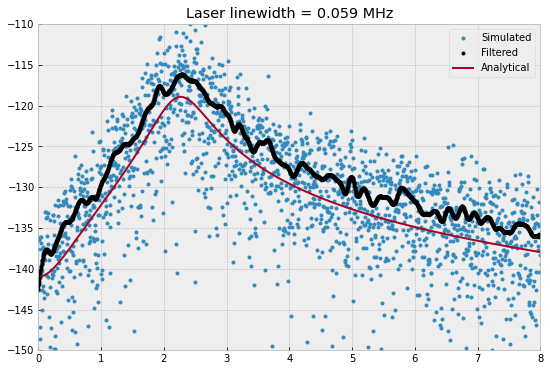

In [137]:
# Compare 
plt.plot(1e-9*F, 10*np.log10(rin),'.',label='Simulated')
plt.plot(1e-9*F, 10*np.log10(rin_t),'k.',label='Filtered')
plt.plot(1e-9*f, 10*np.log10(RIN),label='Analytical')
plt.title('Laser linewidth = %.3f MHz'%(1e-6*phase_noise[0]/(2*np.pi)))
plt.xlim([0,8])
plt.ylim([-150,-110])
plt.legend()